In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict, stack_to_ax

idx = pd.IndexSlice

In [3]:
results = pd.read_csv(
    Path.cwd().parent /
    'summaries' /
    'total_summary_flex.csv',
    index_col=[0,1],
    parse_dates=True
    )

model_balancing_volume = results.loc[results.index.get_level_values(1) == 'balancing_volume']
results = results.loc[~(results.index.get_level_values(1) == 'balancing_volume')]

C:\Users\lukas\AppData\Local\Temp\ipykernel_20544\199033386.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  results = pd.read_csv(


In [4]:
balancing_share = 1 - model_balancing_volume['zonal'].mean() / model_balancing_volume['national'].mean()

In [5]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'bmus_prepared.csv', index_col=0)

In [6]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

all_bids = []

for day in tqdm(sorted(model_balancing_volume.index.get_level_values(0).strftime('%Y-%m-%d').unique())):

    try:
        bids = pd.read_csv(Path.cwd().parent / 'data' / 'base' / f'{day}' / 'bids.csv', index_col=[0,1], parse_dates=True)
    except FileNotFoundError:
        continue

    all_bids.append(bids)

all_bids = pd.concat(all_bids)

100%|██████████| 1078/1078 [00:08<00:00, 124.60it/s]


In [7]:
idx = pd.IndexSlice

real_bid_vol = all_bids.loc[
    idx[:,'vol'],
    # idx['2022-11','vol'],
    all_bids.columns.intersection(
        bmus
        .index[bmus.carrier.isin(['onwind', 'offwind', 'cascade', 'ror', 'PHS'])]
        )
    # :
].sum(axis=1)

real_bid_vol.index = real_bid_vol.index.droplevel(1)
# real_bid_vol = real_bid_vol.groupby(real_bid_vol.index.strftime('%Y-%m')).sum().mul(1e-3)
real_bid_vol = real_bid_vol.groupby(real_bid_vol.index.strftime('%Y-%m')).sum().mul(1e-3)

In [8]:
mmb = (
    # model_balancing_volume.loc['2022-11', 'national']
    model_balancing_volume.loc[:, 'national']
    .groupby(
        model_balancing_volume# .loc['2022-11']
        .index
        .get_level_values(0)
        .strftime('%Y-%m')
        # .strftime('%Y-%m-%d')
    ).sum()
    .mul(1e3)
)

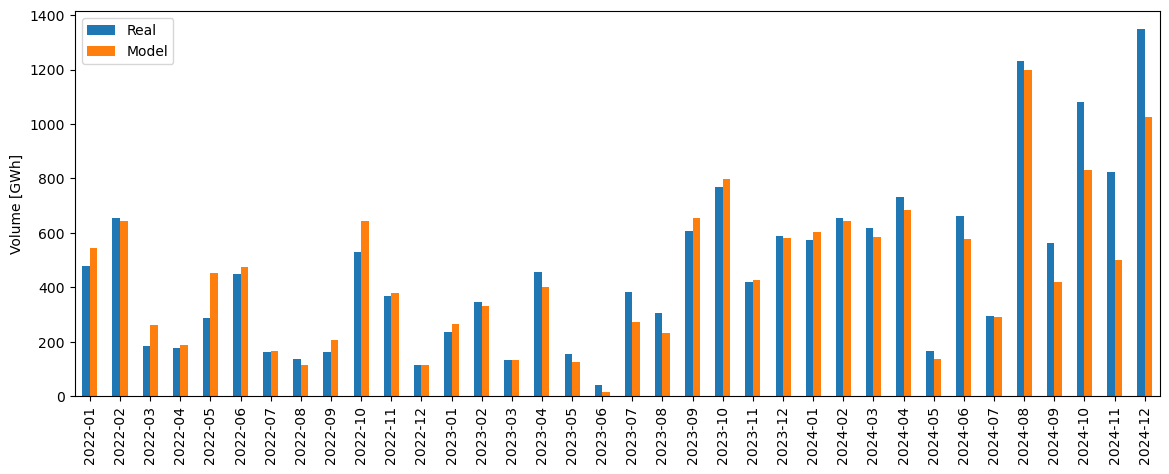

In [9]:
fig, ax = plt.subplots(figsize=(14, 5))

# real_bid_vol.plot.bar(ax=ax)
# mmb.plot.bar(ax=ax, color='red')

plotdata = pd.concat([real_bid_vol, mmb], axis=1)
plotdata.columns = ['Real', 'Model']

plotdata.plot.bar(ax=ax)
ax.set_ylabel('Volume [GWh]')



plt.savefig('balancing_volume_validation.pdf', bbox_inches='tight')
plt.show()

In [10]:
print(plotdata.sum())

Real     16889.209765
Model    15916.831803
dtype: float64


In [11]:
# print('real congestion management bids: ', int(real_bid_vol.drop(index=['2022-11-20', '2022-11-22']).sum().sum()), 'GWh')
# print('model congestion management bids: ', int(mmb.drop(index=['2022-11-20', '2022-11-22']).sum()), 'GWh')
print('real congestion management bids: ', int(real_bid_vol.sum().sum()), 'GWh')
print('model congestion management bids: ', int(mmb.sum()), 'GWh')

real congestion management bids:  16889 GWh
model congestion management bids:  15916 GWh


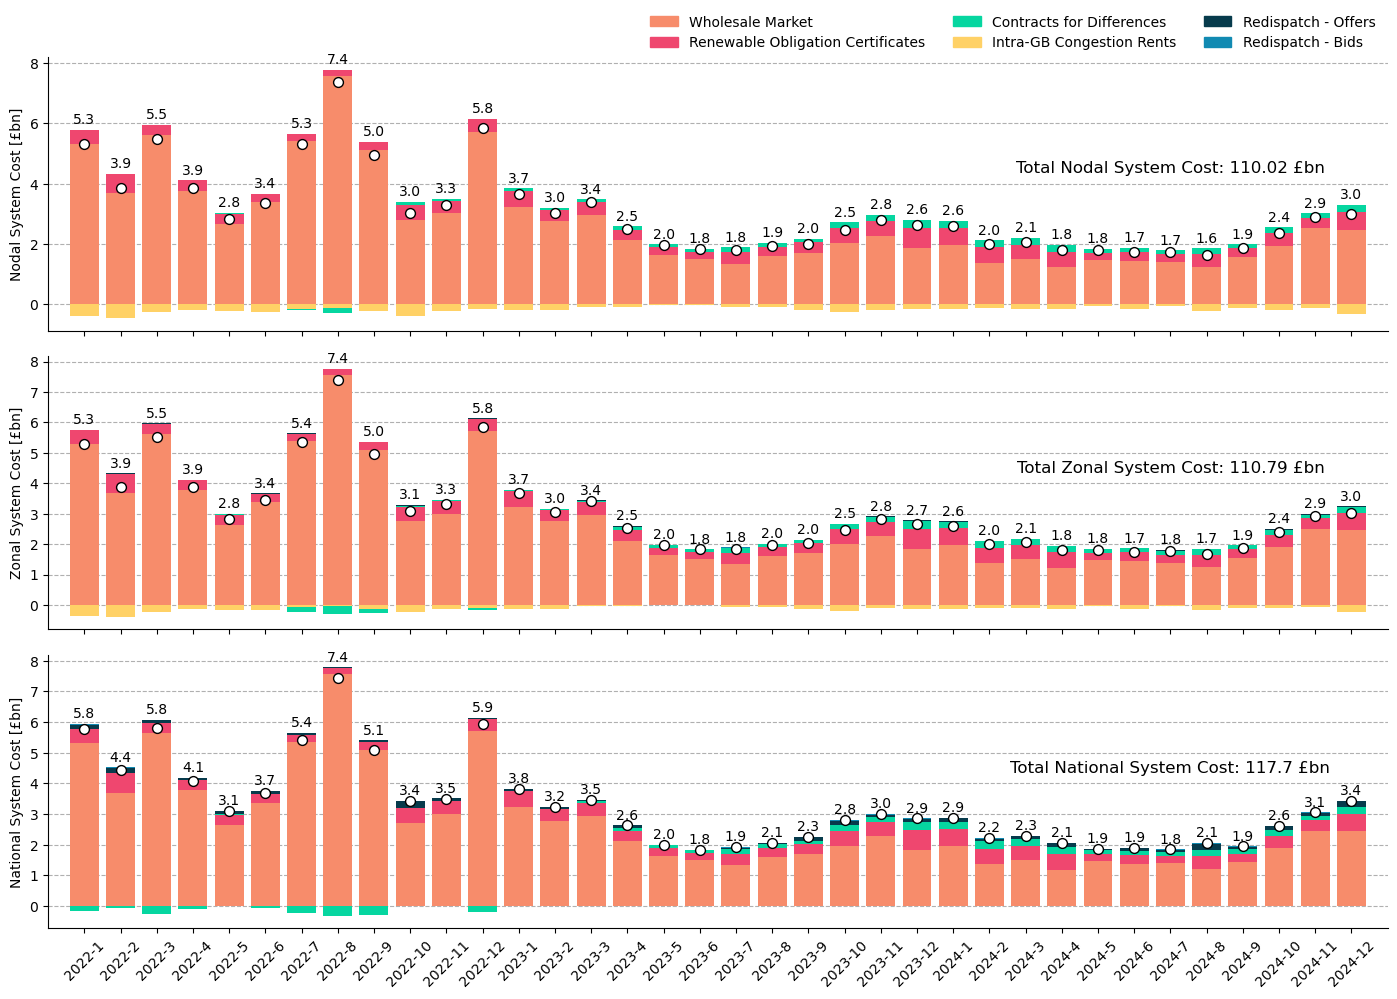

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for col, ax in zip(results.columns, axs):

    ts = results.index.get_level_values(0).unique()

    df_unstack = results.loc[idx[:, :], col].unstack()
    df = df_unstack.groupby([df_unstack.index.year, df_unstack.index.month]).sum().mul(1e-3)

    for m in df.index:
        # stack_to_ax(total_costs, df.loc[[m]], ax)
        stack_to_ax(df.loc[[m]], ax)

    ax.set_ylabel(f'{col.capitalize()} System Cost [£bn]')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(df))

    total_cost = df.sum().sum()
    ax.text(
        len(df) - 6, 4.5,
        f'Total {col.capitalize()} System Cost: {np.around(total_cost, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )

axs[2].tick_params(axis='x', labelrotation=45)

handles, labels = [], []

for name, nice_name in nice_names.items():

    if name == 'wholesale buying':
        continue
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[0].legend(
    handles,
    labels,
    # title='Cost Factors',
    # bbox_to_anchor=(1.01, 1.2),
    bbox_to_anchor=(0.44, 1.2),
    frameon=False,
    ncol=3
    )


plt.tight_layout()

plt.savefig('total_monthly_costs.pdf')
plt.show()

In [13]:
nquants = len(results.index.get_level_values(1).unique())

total_date_range = pd.date_range(
    results.index.get_level_values(0).min().strftime('%Y-%m'),
    results.index.get_level_values(0).max().strftime('%Y-%m'),
    freq='ME').strftime('%Y-%m')

total_hh = pd.date_range(
    results.index.get_level_values(0).min().strftime('%Y-%m-%d'),
    results.index.get_level_values(0).max().strftime('%Y-%m-%d'),
    freq='30min')

missing_share = pd.Series(np.nan, total_date_range)

for m in total_date_range:

    n_modelled = len(results.loc[idx[m, :], :]) / nquants
    n_total = pd.date_range(m, pd.Timestamp(m) + pd.offsets.MonthEnd(1), freq='30min')

    missing_share[m] = 1 - n_modelled / len(n_total)

##### Combined: Total Costs National, Total Costs Zonal, Difference

In [14]:
results.columns

Index(['nodal', 'zonal', 'national'], dtype='object')

In [15]:
def plot_stacked_horizontal_bar(series, ax, right_tick=True):
    """
    Plot a horizontal stacked bar chart with negative values to the left and positive values to the right.
    
    Parameters:
    -----------
    series : pd.Series
        Series containing values to plot, with negative and positive values.
    ax : matplotlib.axes.Axes
        The axes to plot on.
    """
    # Separate positive and negative values
    pos_series = series[series > 0].copy()
    neg_series = series[series < 0].copy()
    
    # Sort values for better visualization
    pos_series = pos_series.sort_values(ascending=False)
    neg_series = neg_series.sort_values(ascending=True)
    
    # Calculate cumulative sums for stacking
    # pos_cumsum = pos_series.cumsum()
    # neg_cumsum = neg_series.cumsum()
    
    # Calculate the total negative value (for x-axis alignment)
    total_neg = neg_series.sum()
    
    # Plot negative values (to the left)
    left = total_neg
    for idx, val in neg_series.items():
        width = abs(val)
        left += width
        ax.barh(0, -width, left=left, height=0.5, label=idx, color=color_dict.get(idx, 'gray'))
    
    # Plot positive values (to the right)
    left = 0
    for idx, val in pos_series.items():
        ax.barh(0, val, left=left, height=0.5, label=idx, color=color_dict.get(idx, 'gray'))
        left += val
    
    # Set x-ticks with one tick at the boundary between negative and positive

    ax.scatter([total_neg + pos_series.sum()], [0], color='white', edgecolor='black', s=100, marker='o')

    # ax.set_xticks([0, total_neg, total_neg + pos_series.sum()])
    # ax.set_xticklabels(['0', f'{total_neg:.1f}', f'{total_neg + pos_series.sum():.1f}'])
    # Remove y-ticks and set labels
    xticks = ax.get_xticks()
    xticklabels = ax.get_xticklabels()

    # Add the key points to the x-ticks without creating text objects
    more_ticks = [0, total_neg]
    if right_tick:
        more_ticks.append(total_neg + pos_series.sum())
    xticks = np.unique(np.concatenate([xticks, more_ticks]))
    xticklabels = [f'{x:.1f}' for x in xticks]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_yticks([])
    ax.set_xlabel('(£bn)')
    # ax.axvline(x=total_neg, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlim(total_neg, pos_series.sum())
    ax.set_ylim(-0.25, 0.25)

    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    
    return ax

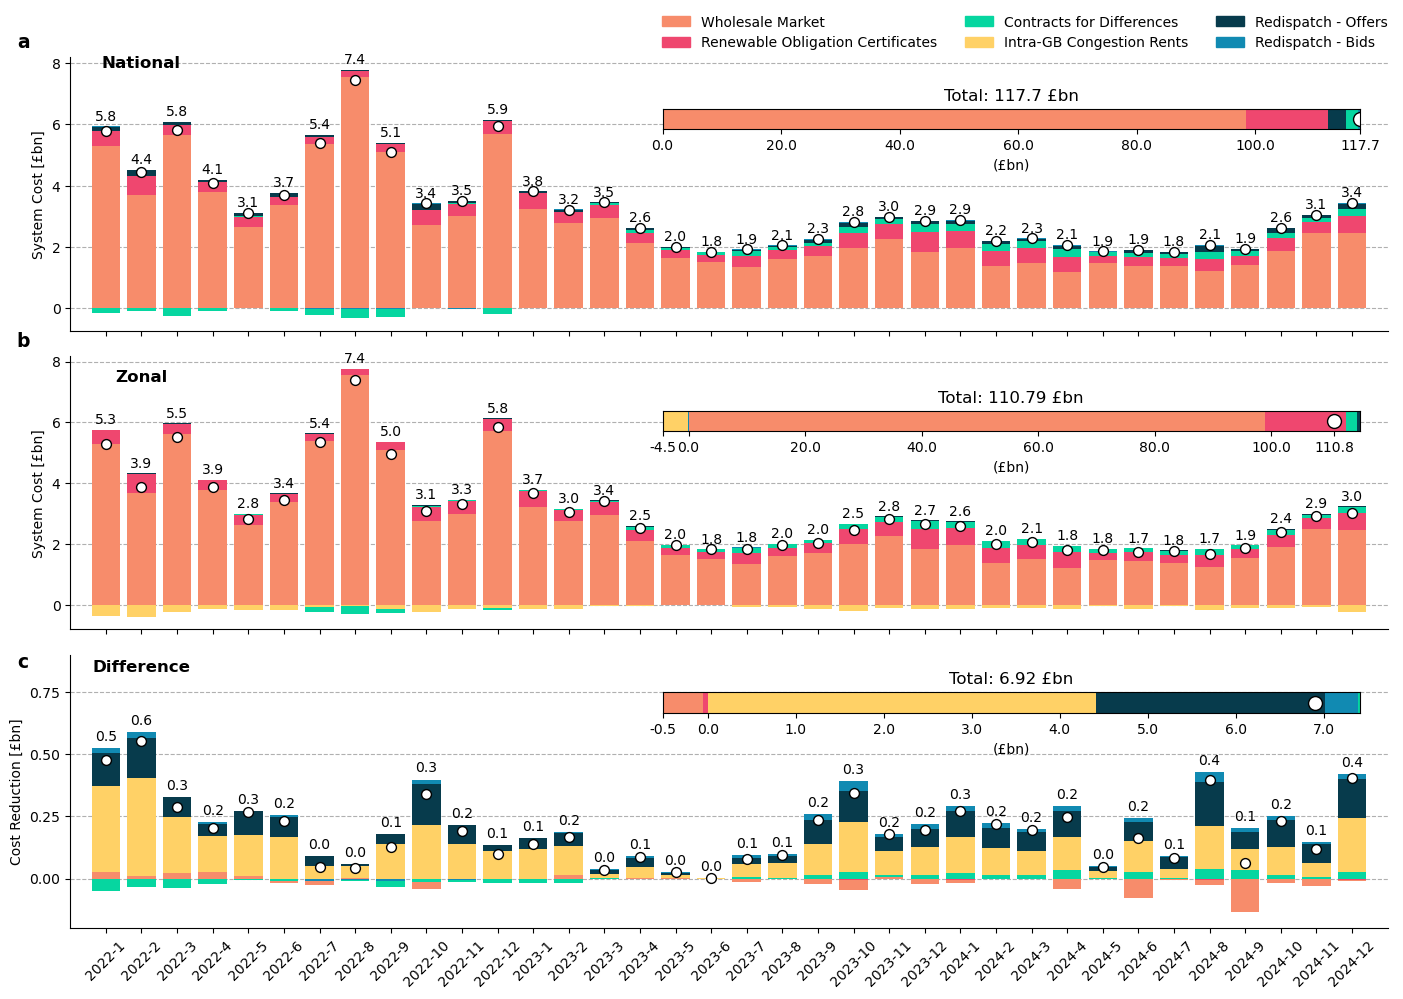

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

totals = {}

for col, ax in zip(['national', 'zonal'], axs[:2]):

    ts = results.index.get_level_values(0).unique()

    df_unstack = results.loc[idx[:, :], col].unstack()
    df = df_unstack.groupby([df_unstack.index.year, df_unstack.index.month]).sum().mul(1e-3)

    for m in df.index:
        # stack_to_ax(total_costs, df.loc[[m]], ax)
        stack_to_ax(df.loc[[m]], ax)

    ax.set_ylabel(f'System Cost [£bn]')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(df))

    total_cost = df.sum().sum()
    totals[col] = total_cost

    '''
    ax.text(
        len(df) - 6, 5,
        f'Total: {np.around(total_cost, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )
    '''
    ax.text(
        1, {'national': 8, 'zonal': 7.5}[col],
        f'{col.capitalize()}',
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        # transform=ax.transAxes
    )
    ax.set_yticks([0, 2, 4, 6, 8])


    y_shift = 0.01 if col == 'zonal' else 0.04

    # Create a new axis based on relative coordinates to ax
    new_ax = ax.figure.add_axes([
        ax.get_position().x0 + 0.32, 
        ax.get_position().y0 + ax.get_position().height * 0.8 + y_shift, 
        ax.get_position().width * 0.6, 
        ax.get_position().height * 0.09
        ])

    plot_stacked_horizontal_bar(df.sum(), new_ax)
    new_ax.set_title(f'Total: {np.around(total_cost, decimals=2)} £bn')
    


for layout, ax in zip(['zonal'], axs[2:]):

    ss = (results['national'] - results[layout]).unstack()

    ss = (
        ss
        .groupby([ss.index.year, ss.index.month]).sum().mul(1e-3)
    )
    for m in ss.index:
        stack_to_ax(ss.loc[[m]], ax, text_y_offset=0.03)

    ax.set_ylabel(f'Cost Reduction [£bn]')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(ss))

    total_cost = ss.sum().sum()

    if layout == 'zonal':
        y = 0.625
    else:
        y = 0.65

    total_diff = totals['national'] - totals[layout]

    '''
    ax.text(
        len(ss) - 6, y,
        f'Total: {np.around(total_diff, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )
    '''

    new_ax = ax.figure.add_axes([
        ax.get_position().x0 + 0.32,
        ax.get_position().y0 + ax.get_position().height * 0.8 + 0.0, 
        ax.get_position().width * 0.6, 
        ax.get_position().height * 0.09
        ])

    plot_stacked_horizontal_bar(ss.sum(), new_ax, right_tick=False)
    new_ax.set_title(f'Total: {np.around(total_diff, decimals=2)} £bn')

    ax.text(
        1, 0.85,
        'Difference',
        ha='center',
        va='center',
        fontweight='bold',
        fontsize=12,
        # transform=ax.transAxes
    )
    ax.set_yticks([0, 0.25, 0.5, 0.75])
    ax.set_ylim(-0.2, 0.9)


axs[2].tick_params(axis='x', labelrotation=45)

handles, labels = [], []

for name, nice_name in nice_names.items():

    if name == 'wholesale buying':
        continue
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[0].legend(
    handles,
    labels,
    # title='Cost Factors',
    # bbox_to_anchor=(1.01, 1.2),
    bbox_to_anchor=(0.44, 1.2),
    frameon=False,
    ncol=3
    )

plt.tight_layout()

for ax, text, y in zip(axs, ['a', 'b', 'c'], [8.5, 8.5, 0.85]):
    ax.text(
        -2.5, y, text, weight='bold', fontsize=13.5,
    )

plt.savefig('total_monthly_costs_w_comparison.pdf')
plt.show()

In [17]:
rev_nat = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_national.csv', index_col=[0,1], parse_dates=True)
rev_zon = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_zonal.csv', index_col=[0,1], parse_dates=True)

In [18]:
interconnectors = [
    'IFA1',
    'Moyle',
    'BritNed',
    'IFA2',
    'EastWest',
    'ElecLink',
    'NSL',
    'Nemo'
]

# Remove interconnectors from revenue dataframes
rev_nat = rev_nat.loc[~rev_nat.index.get_level_values(0).isin(interconnectors)]
rev_zon = rev_zon.loc[~rev_zon.index.get_level_values(0).isin(interconnectors)]

from plotting_constants import color_dict

In [19]:
ts = pd.read_csv(
    Path.cwd().parent / 'summaries' / 'total_summary_flex.csv', 
    index_col=[0,1], 
    # parse_dates=[0]
    )
ts = ts.loc[idx[:, 'balancing_volume'], ['zonal', 'national']]
ts = ts.groupby(ts.index.get_level_values(0).str[:7]).sum().mul(1e3)

curtailment = ts['national'] - ts['zonal']

who_diff = rev_zon.loc[idx[:, 'wholesale_revenue'], :].sum() - rev_nat.loc[idx[:, 'wholesale_revenue'], :].sum()
who_diff = who_diff.groupby(who_diff.index.get_level_values(0).str[:7]).sum().mul(1e-9)

who_diff

2022-01   -0.414435
2022-02   -0.446026
2022-03   -0.271182
2022-04   -0.178047
2022-05   -0.173786
2022-06   -0.159567
2022-07   -0.031082
2022-08   -0.054622
2022-09   -0.140581
2022-10   -0.207242
2022-11   -0.147574
2022-12   -0.112527
2023-01   -0.131392
2023-02   -0.151154
2023-03   -0.021333
2023-04   -0.057021
2023-05   -0.016365
2023-06   -0.001038
2023-07   -0.046112
2023-08   -0.063604
2023-09   -0.119890
2023-10   -0.192054
2023-11   -0.115895
2023-12   -0.112575
2024-01   -0.149026
2024-02   -0.119278
2024-03   -0.106281
2024-04   -0.114774
2024-05   -0.031465
2024-06   -0.083963
2024-07   -0.036914
2024-08   -0.185189
2024-09    0.012805
2024-10   -0.110481
2024-11   -0.041897
2024-12   -0.238204
dtype: float64

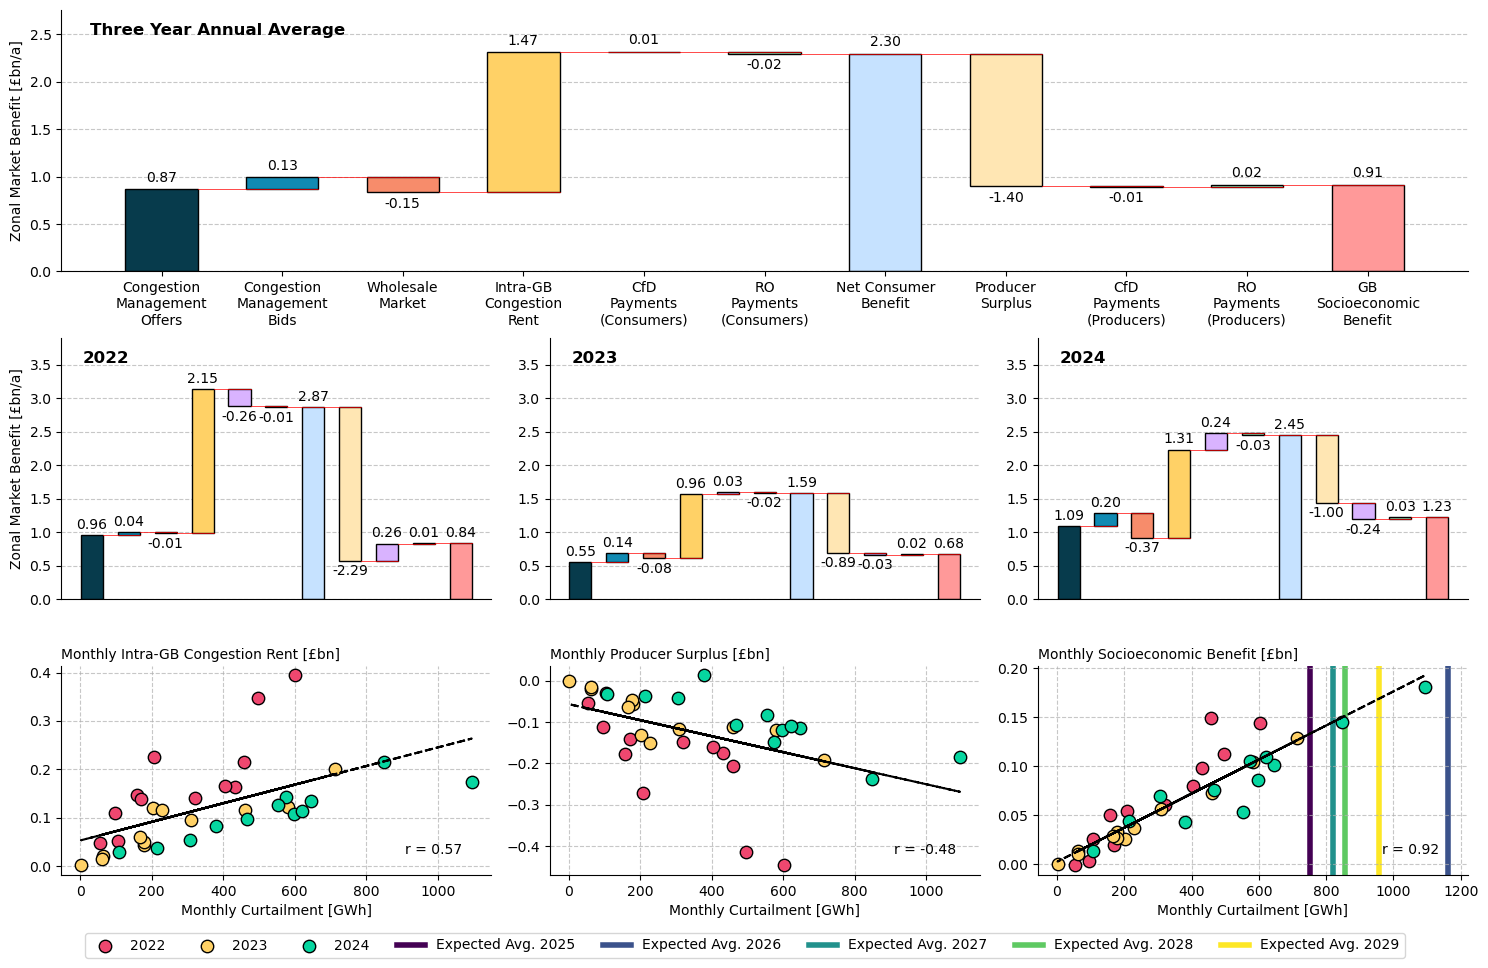

In [20]:
corr_plot = ss.copy()

corr_plot['curtailment'] = curtailment.values
corr_plot['producer_surplus'] = who_diff.values

corr_plot.drop(columns=['cfd_payments', 'roc_payments'], inplace=True)

corr_plot['welfare'] = corr_plot.drop(columns=['curtailment']).sum(axis=1)

# Define the columns to plot in correlation plots
columns_to_plot = ['congestion_rent', 'producer_surplus', 'welfare']

# Define colors for each year for correlation plots
colors = {2022: '#ef476f', 2023: '#ffd166', 2024: '#06d6a0'}

# Create a figure with 3 rows - top row has 1 plot, middle row has 3 plots, bottom row has 3 correlation plots
fig, axs = plt.subplots(3, 3, figsize=(15, 10), 
                        gridspec_kw={'height_ratios': [1, 1, 0.8], 
                                    'width_ratios': [1, 1, 1]})

# Make the top plot span all three columns
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:
    ax.remove()
axs[0, 0] = fig.add_subplot(gs[0, :])

# Define the years to process
years = ['total', '2022', '2023', '2024']

# Process each year and plot on the appropriate axis
for i, year in enumerate(years):
    if i == 0:
        ax = axs[0, 0]  # Top row for 'total'
    else:
        ax = axs[1, i-1]  # Middle row for individual years
    
    # Process data for the current year
    if year != 'total':
        rev_nat_year = rev_nat.loc[:, rev_nat.columns.str.contains(year)]
        rev_zon_year = rev_zon.loc[:, rev_zon.columns.str.contains(year)]
    else:
        rev_nat_year = rev_nat.mul(1/3)
        rev_zon_year = rev_zon.mul(1/3)

    idx = pd.IndexSlice
    rev_nat_val = rev_nat_year.loc[idx[:, 'wholesale_revenue'], :].sum().sum() / 1e9
    rev_zon_val = rev_zon_year.loc[idx[:, 'wholesale_revenue'], :].sum().sum() / 1e9

    diff = rev_zon_val - rev_nat_val

    wf = pd.Series(
        index=[
            'offer_cost',
            'bid_cost',
            'wholesale',
            'congestion_rent',
            'cfd_payments_consumer',
            'roc_payments_consumer',
            'net_consumer_benefit',
            'producer_surplus',
            'cfd_payments_producer',
            'roc_payments_producer',
            'socioeconmic_benefit'
            ],
    )

    if year != 'total':
        hold = ss.loc[idx[int(year), :]].sum()
    else:
        hold = ss.sum() / 3

    wf.loc[wf.index.intersection(hold.index)] = hold.loc[wf.index.intersection(hold.index)]

    wf.loc['cfd_payments_consumer'] = hold.loc['cfd_payments']
    wf.loc['cfd_payments_producer'] = - hold.loc['cfd_payments']

    wf.loc['roc_payments_consumer'] = hold.loc['roc_payments']
    wf.loc['roc_payments_producer'] = - hold.loc['roc_payments']

    wf.loc['net_consumer_benefit'] = hold.sum()
    wf.loc['producer_surplus'] = diff + hold.loc['bid_cost']

    wf.loc['socioeconmic_benefit'] = (
        wf.loc['net_consumer_benefit'] + 
        wf.loc['producer_surplus'] - 
        wf.loc['cfd_payments_consumer'] - 
        wf.loc['roc_payments_consumer']
    )

    # Define the components for the waterfall chart
    components = wf.index.tolist()
    values = wf.values

    # Use the color dictionary or default to a standard color if not in dict
    # Define fallback colors for components not in color_dict
    fallback_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#d9b3ff', '#b3ffcc', '#c6e2ff', '#ffe6b3', '#d9b3ff', '#b3ffcc']
    colors_wf = []
    for j, component in enumerate(components):
        if component in color_dict:
            colors_wf.append(color_dict[component])
        else:
            # Use a fallback color from our list, cycling if needed
            fallback_idx = j % len(fallback_colors)
            colors_wf.append(fallback_colors[fallback_idx])

    # Starting positions for each bar
    bottoms = np.zeros_like(values)

    # First 6 entries begin at the height of the previous one
    for j in range(1, 6):
        bottoms[j] = bottoms[j-1] + values[j-1]

    # net_consumer_benefit starts at 0
    bottoms[6] = 0

    # The next 3 entries continue from previous bar's height
    for j in range(7, 10):
        bottoms[j] = bottoms[j-1] + values[j-1]

    # socioeconomic_benefit starts from the bottom
    bottoms[10] = 0

    # Create the bars
    running_total = 0
    width = 0.6
    for j, (component, value, bottom, color) in enumerate(zip(components, values, bottoms, colors_wf)):
        ax.bar(j, value, bottom=bottom, color=color, edgecolor='black', label=component, width=width)
        
        # Add value labels on the bars
        if value >= 0:
            va = 'bottom'
            y_pos = bottom + value + 0.05
        else:
            va = 'top'
            y_pos = bottom + value - 0.05
        
        ax.text(j, y_pos, f'{value:.2f}', ha='center', va=va)
        
        if j > 0 and j < 6:  # First section (up to net_consumer_benefit)
            ax.plot([j-1 + width/2, j + width/2], [running_total, running_total], 'r', linewidth=.5)
            running_total += value
        elif j == 6:  # Reset for net_consumer_benefit
            running_total = value
            ax.plot([j-1 + width/2, j + width/2], [running_total, running_total], 'r', linewidth=.5)
        elif j > 6 and j < 11:  # Second section (up to socioeconmic_benefit)
            ax.plot([j-1 + width/2, j + width/2], [running_total, running_total], 'r', linewidth=.5)
            running_total += value
        elif j == 0:
            running_total = value

    friendly_labels = {
        'offer_cost': 'Congestion\nManagement\nOffers',
        'bid_cost': 'Congestion\nManagement\nBids',
        'wholesale': 'Wholesale\nMarket',
        'congestion_rent': 'Intra-GB\nCongestion\nRent',
        'cfd_payments_consumer': 'CfD\nPayments\n(Consumers)',
        'roc_payments_consumer': 'RO\nPayments\n(Consumers)',
        'net_consumer_benefit': 'Net Consumer\nBenefit',
        'producer_surplus': 'Producer\nSurplus',
        'cfd_payments_producer': 'CfD\nPayments\n(Producers)',
        'roc_payments_producer': 'RO\nPayments\n(Producers)',
        'socioeconmic_benefit': 'GB\nSocioeconomic\nBenefit'
    }

    if i < 2:
        ax.set_ylabel('Zonal Market Benefit [£bn/a]')
    
    # Set xticks only for the top row, remove for bottom row
    if i == 0:  # Top row
        ax.set_xticks(range(len(components)))
        ax.set_xticklabels([friendly_labels[comp] for comp in components])
    else:  # Middle row
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Add title for each subplot
    if year == 'total':
        # Add the year as text in the upper left corner instead of using a legend
        ax.text(0.02, 0.95, f'Three Year Annual Average', transform=ax.transAxes, 
                fontsize=12, fontweight='bold', va='top', ha='left')
    else:
        # Add the year as text in the upper left corner instead of using a legend
        ax.text(0.05, 0.95, f'{year}', transform=ax.transAxes, 
                fontsize=12, fontweight='bold', va='top', ha='left')

    # Add a grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    # Adjust y-axis limits
    if i == 0:
        ax.set_ylim(0, wf.max() * 1.2)
    else:
        ax.set_ylim(0, 3.9)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add correlation plots in the bottom row
markers = []
for i, col in enumerate(columns_to_plot):
    ax = axs[2, i]
    
    # Plot points with different colors based on year
    for year in [2022, 2023, 2024]:
        year_data = corr_plot.loc[year]
        scatter = ax.scatter(
            year_data['curtailment'], 
            year_data[col],
            s=80,
            color=colors[year],
            edgecolor='k',
            label=year if i == 0 else None  # Only add to legend for the first subplot
        )
        if i == 0:
            markers.append(scatter)
            
    
    # Add trend line for all data
    z = np.polyfit(corr_plot['curtailment'], corr_plot[col], 1)
    p = np.poly1d(z)
    ax.plot(corr_plot['curtailment'], p(corr_plot['curtailment']), "k--")
    ax.set_xlabel('Monthly Curtailment [GWh]')
    ax.set_ylabel('')
    
    # Add frontend-friendly strings for y-quantities
    if col == 'congestion_rent':
        ax.text(-0., 1.02, 'Monthly Intra-GB Congestion Rent [£bn]', transform=ax.transAxes, ha='left', va='bottom')
    elif col == 'producer_surplus':
        ax.text(-0., 1.02, 'Monthly Producer Surplus [£bn]', transform=ax.transAxes, ha='left', va='bottom')
    elif col == 'welfare':
        ax.text(-0., 1.02, 'Monthly Socioeconomic Benefit [£bn]', transform=ax.transAxes, ha='left', va='bottom')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add grid and set it below the plot elements
    ax.grid(axis='both', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    # Add correlation coefficient
    corr = np.corrcoef(corr_plot['curtailment'], corr_plot[col])[0, 1]
    ax.annotate(f"r = {corr:.2f}", xy=(0.8, 0.1), xycoords='axes fraction')

expected_curtailment = { # from https://www.neso.energy/document/322331/download, slide 32
    '2025': 11_000 / 12 * balancing_share,
    '2026': 17_000 / 12 * balancing_share,
    '2027': 12_000 / 12 * balancing_share,
    '2028': 12_500 / 12 * balancing_share,
    '2029': 14_000 / 12 * balancing_share,
}

# Add vertical lines for expected curtailment in the bottom right plot (welfare)
ax = axs[2, 2]  # Bottom right plot
cmap = plt.cm.viridis  # Use viridis colormap
forecast_lines = []
years = list(expected_curtailment.keys())
for i, year in enumerate(years):
    # Calculate color position in the colormap
    color_pos = i / (len(years) - 1)
    color = cmap(color_pos)
    # Add vertical line
    line = ax.axvline(x=expected_curtailment[year], color=color, linestyle='-', linewidth=4, zorder=0)
    forecast_lines.append(line)

# Add a single legend for the correlation plots and forecast lines
legend_elements = [(markers[i], f'{2022+i}') for i in range(len(markers))]
legend_elements += [(forecast_lines[i], f'Expected Avg. {years[i]}') for i in range(len(forecast_lines))]

fig.legend([elem[0] for elem in legend_elements], 
           [elem[1] for elem in legend_elements],
           loc='lower center', ncol=len(legend_elements), bbox_to_anchor=(0.5, 0.03),
           handler_map={type(forecast_lines[0]): plt.matplotlib.legend_handler.HandlerLine2D()})

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  # Make more room for the expanded legend

plt.savefig('socioeconomic_benefits_with_correlations.pdf', bbox_inches='tight')
plt.show()

In [21]:
dispatch = pd.read_csv(
    Path.cwd().parent / 'summaries' / 'total_unit_dispatch_flex.csv', index_col=[0,1,2]
)

In [22]:
import yaml

with open(Path.cwd().parent / 'data' / 'interconnection_helpers.yaml', 'r') as f:
    interconnection_capacities = yaml.safe_load(f)

In [23]:
carrier = 'wind'

bmus = pd.read_csv(Path.cwd().parent / 'data' / 'prerun' / 'prepared_bmus.csv', index_col=0)
bmus


,carrier,bus,lon,lat
NationalGridBmUnit,,,,
IBG-EGEN1,interconnector,4969,0.6530000000000001,51.46000000000001
IBG-ENGI1,interconnector,4969,0.6530000000000001,51.46000000000001
IBG-RSQ1,interconnector,4969,0.6530000000000001,51.46000000000001
IVD-VKL1,interconnector,7909,-0.221,52.931
IVG-VKL1,interconnector,7909,-0.221,52.931
...,...,...,...,...
SFERD-1,demand_flex,distributed,distributed,distributed
EAS-SEL01,demand_flex,distributed,distributed,distributed
SEE-PGU01,demand_flex,distributed,distributed,distributed


In [70]:
corr_plot

wholesale  congestion_rent  offer_cost  bid_cost  curtailment  \
2022 1    0.026510         0.346982    0.131804  0.021251   497.295012   
     2    0.009225         0.394445    0.160955  0.025022   601.930394   
     3    0.022389         0.224381    0.081876 -0.002812   207.183715   
     4    0.026147         0.146148    0.049101  0.006934   159.080131   
     5    0.011351         0.163010    0.098058 -0.000229   431.466229   
     6   -0.017286         0.166391    0.081647  0.008776   404.494674   
     7   -0.025038         0.050959    0.039205 -0.008524   105.896712   
     8    0.001298         0.047818    0.010049 -0.005502    54.624019   
     9   -0.008503         0.139384    0.040359 -0.010663   170.973173   
     10  -0.042279         0.215822    0.165255  0.017505   459.257042   
     11  -0.000425         0.140397    0.073409 -0.004981   320.165626   
     12  -0.016777         0.109918    0.025952 -0.002924    96.449034   
2023 1   -0.004002         0.119016    0.042485 -0.000557   203.029388   
     2    0.015567         0.115110    0.051405  0.005756   228.020579   
     3   -0.002125         0.019625    0.014834  0.003175    62.248293   
     4    0.003967         0.043954    0.034578  0.007964   179.489048   
     5    0.001027         0.014040    0.009231  0.003192    61.981509   
     6   -0.000188         0.001085    0.000260  0.000144     1.935464   
     7   -0.012518         0.049403    0.024159  0.011998   178.466999   
     8   -0.002250         0.059312    0.027764  0.007711   166.828923   
     9   -0.020125         0.122512    0.095810  0.026216   581.365014   
     10  -0.044461         0.200501    0.124679  0.040396   713.124110   
     11   0.008273         0.094657    0.056991  0.012825   309.450738   
     12  -0.020624         0.115880    0.072499  0.017328   459.583473   
2024 1   -0.015733         0.142608    0.104819  0.022412   574.074709   
     2   -0.001888         0.108153    0.080111  0.018744   596.957452   
     3   -0.003448         0.097551    0.073517  0.014477   467.068954   
     4   -0.042385         0.133758    0.102958  0.021347   646.132879   
     5   -0.001164         0.028214    0.016940  0.001114   108.009561   
     6   -0.079064         0.125782    0.074643  0.016275   554.132174   
     7   -0.007281         0.037075    0.046179  0.004815   214.979070   
     8   -0.024912         0.174339    0.174707  0.041506  1094.681319   
     9   -0.135302         0.082973    0.068923  0.014251   379.901043   
     10  -0.018552         0.113169    0.109667  0.015500   620.922731   
     11  -0.028852         0.053905    0.078956  0.007830   305.521303   
     12  -0.010421         0.214562    0.157437  0.021561   848.276650   

         producer_surplus   welfare  
2022 1          -0.414435  0.112113  
     2          -0.446026  0.143621  
     3          -0.271182  0.054652  
     4          -0.178047  0.050284  
     5          -0.173786  0.098405  
     6          -0.159567  0.079962  
     7          -0.031082  0.025521  
     8          -0.054622 -0.000959  
     9          -0.140581  0.019995  
     10         -0.207242  0.149061  
     11         -0.147574  0.060826  
     12         -0.112527  0.003642  
2023 1          -0.131392  0.025549  
     2          -0.151154  0.036685  
     3          -0.021333  0.014176  
     4          -0.057021  0.033442  
     5          -0.016365  0.011126  
     6          -0.001038  0.000264  
     7          -0.046112  0.026930  
     8          -0.063604  0.028932  
     9          -0.119890  0.104522  
     10         -0.192054  0.129061  
     11         -0.115895  0.056851  
     12         -0.112575  0.072509  
2024 1          -0.149026  0.105079  
     2          -0.119278  0.085843  
     3          -0.106281  0.075815  
     4          -0.114774  0.100903  
     5          -0.031465  0.013640  
     6          -0.083963  0.053673  
     7          -0.036914  0.043874  
     8          -0.185189  0.180452  
     9          

In [24]:
dna = dispatch.loc[idx[:, 'national', 'redispatch']].replace(np.nan, 0.)
dzo = dispatch.loc[idx[:, 'zonal', 'redispatch']].replace(np.nan, 0.)

In [25]:
disdiff = (dzo.sum(axis=1).mul(1e-3) - dna.sum(axis=1).mul(1e-3)).sort_values().to_frame().rename(columns={0: 'diff'})
disdiff

,diff
MRWD-1,-236.485189
SEAB-1,-181.051564
KEAD-2,-178.544356
DRAXX-3,-158.671071
DRAXX-2,-147.928556
...,...
ElecLink,629.273848
BritNed,683.868801
Nemo,765.685019
IFA1,769.404690


In [26]:
bmus.carrier.unique()

array(['interconnector', 'battery', 'fossil', 'onwind', 'hydro',
       'cascade', 'biomass', 'load', 'offwind', 'solar', 'PHS', 'nuclear',
       'demand_flex'], dtype=object)

In [27]:
totflex = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex.csv', index_col=[0,1,2], parse_dates=True).replace(np.nan, 0.)

In [28]:
totflex.index.get_level_values(2).unique()

Index(['bid_cost', 'cfd', 'ftr', 'offer_cost', 'roc', 'wholesale', 'level3'], dtype='object')

In [29]:
cols = ['bid_cost', 'cfd', 'offer_cost', 'roc', 'wholesale']
rev_nat = totflex.loc[idx[:, 'national', cols]].sort_index()
rev_zon = totflex.loc[idx[:, 'zonal', cols]].sort_index()

rev_nat.index = rev_nat.index.droplevel(1)
rev_zon.index = rev_zon.index.droplevel(1)

In [30]:
def get_units(carrier):
    if isinstance(carrier, list):
        return bmus.loc[bmus.carrier.isin(carrier)].index
    elif isinstance(carrier, str) and carrier != 'interconnector':
        units = bmus.loc[bmus.carrier.str.contains(carrier)].index
    else:
        units = pd.Index(list(interconnection_capacities['interconnection_mapper'].keys()))
    return units

In [31]:
carriers = ['wind', 'battery', 'fossil', 'hydro', 'cascade', 'biomass', 'PHS', 'nuclear', 'interconnector']
results = pd.Series(0, index=carriers)

for carrier in carriers:
    units = get_units(carrier)
    results.loc[carrier] = disdiff.loc[disdiff.index.intersection(units), 'diff'].sum()

<Axes: >

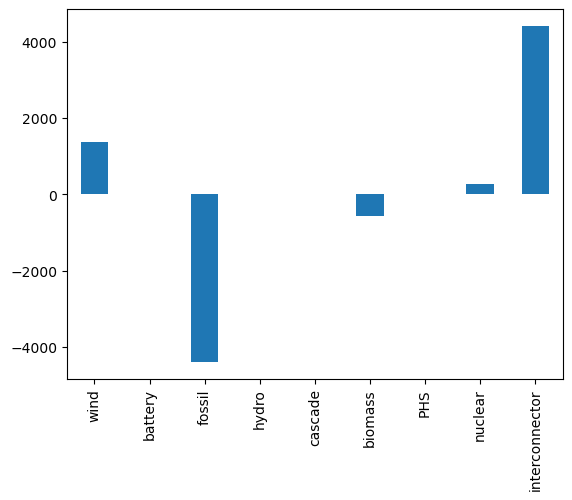

In [32]:
results.plot.bar()

In [33]:
rna = rev_nat.replace(np.nan, 0.).groupby(level=0).sum()
rzo = rev_zon.replace(np.nan, 0.).groupby(level=0).sum()

In [34]:
units = get_units('fossil')
rev_nat.loc[idx[units.intersection(rev_nat.index.get_level_values(0)), :, :], :]

2022-01-01  2022-01-02  2022-01-03  2022-01-04  \
BRGDG-1 bid_cost           0.0         0.0         0.0         0.0   
        cfd                0.0         0.0         0.0         0.0   
        offer_cost         0.0         0.0         0.0         0.0   
        roc                0.0         0.0         0.0         0.0   
        wholesale          0.0         0.0         0.0         0.0   
...                        ...         ...         ...         ...   
SHBA-2  bid_cost           0.0         0.0         0.0         0.0   
        cfd                0.0         0.0         0.0         0.0   
        offer_cost         0.0         0.0         0.0         0.0   
        roc                0.0         0.0         0.0         0.0   
        wholesale          0.0         0.0         0.0         0.0   

                    2022-01-05    2022-01-06  2022-01-07  2022-01-08  \
BRGDG-1 bid_cost           0.0      0.000000         0.0         0.0   
        cfd                0.0      0.000000         0.0         0.0   
        offer_cost         0.0  69418.857483         0.0         0.0   
        roc                0.0      0.000000         0.0         0.0   
        wholesale          0.0      0.000000         0.0         0.0   
...                        ...           ...         ...         ...   
SHBA-2  bid_cost           0.0      0.000000         0.0         0.0   
        cfd                0.0      0.000000         0.0         0.0   
        offer_cost         0.0      0.000000         0.0         0.0   
        roc                0.0      0.000000         0.0         0.0   
        wholesale          0.0      0.000000         0.0         0.0   

                    2022-01-09     2022-01-10  ...  2024-12-22     2024-12-23  \
BRGDG-1 bid_cost           0.0    5764.453522  ...         0.0       0.000000   
        cfd                0.0       0.000000  ...         0.0       0.000000   
        offer_cost         0.0       0.000000  ...         0.0       0.000000   
        roc                0.0       0.000000  ...         0.0       0.000000   
        wholesale          0.0  162404.864530  ...         0.0       0.000000   
...                        ...            ...  ...         ...            ...   
SHBA-2  bid_cost           0.0       0.000000  ...         0.0       0.000000   
        cfd                0.0       0.000000  ...         0.0       0.000000   
        offer_cost         0.0       0.000000  ...         0.0  132543.410709   
        roc                0.0       0.000000  ...         0.0       0.000000   
        wholesale          0.0       0.000000  ...         0.0  432001.149075   

                       2024-12-24     2024-12-25    2024-12-26    2024-12-27  \
BRGDG-1 bid_cost         0.000000       0.000000  6.279649e+03  3.300120e-06   
        cfd              0.000000       0.000000  0.000000e+00  0.000000e+00   
        offer_cost       0.000000       0.000000  0.000000e+00  0.000000e+00   
        roc              0.000000       0.000000  0.000000e+00  0.000000e+00   
        wholesale        0.000000       0.000000  2.021926e+04  4.056619e+04   
...                           ...            ...           ...           ...   
SHBA-2  bid_cost    446214.580489  295687.468698  0.000000e+00  0.000000e+00   
        cfd              0.000000       0.000000  0.000000e+00  0.000000e+00   
        offer_cost   22373.721789  101428.973273  0.000000e+00  0.000000e+00   
        roc              0.000000       0.000000  0.000000e+00  0.000000e+00   
        wholesale   745992.328439  262697.104508  1.254840e+06  1.883817e+06   

                      2024-12-28   2024-12-29  2024-12-30  2024-12-31  
BRGDG-1 bid_cost    0.000000e+00      0.00000         0.0         0.0  
        cfd         0.000000e+00      0.00000         0.0         0.0  
        offer_cost  1.757725e+04      0.00000         0.0         0.0  
        roc         0.000000e+00      0.00000         0.0         0.0  
        wholesale   

fossil
-1494.6010853717928
wind
-4293.349114203625
interconnector
317.50149342901454


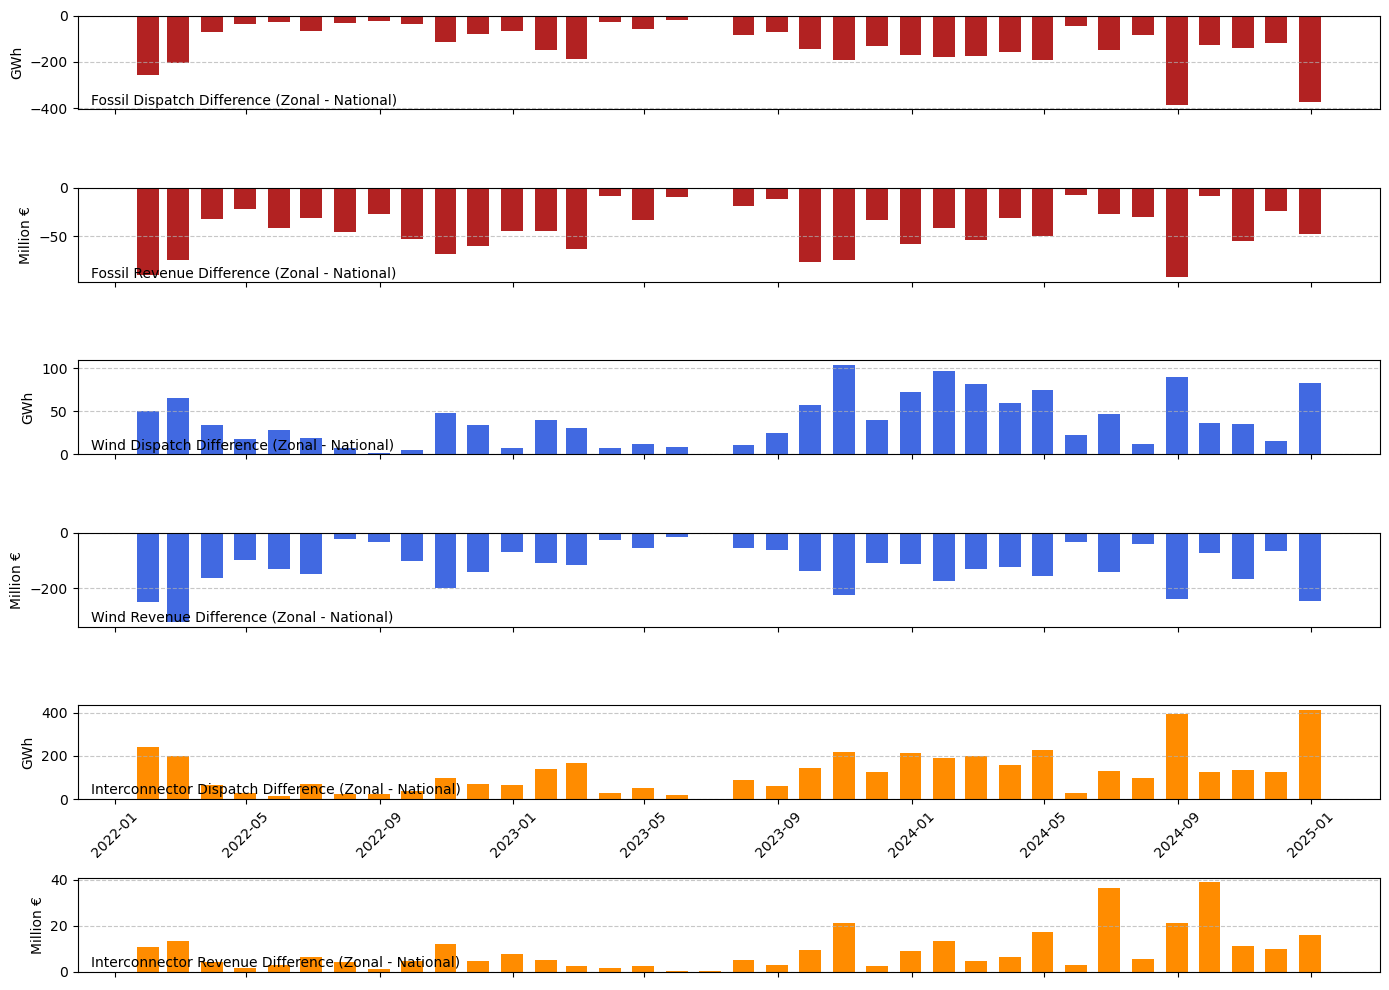

In [35]:
disdiff_detailed = (dzo.mul(1e-3) - dna.mul(1e-3))
revdiff_detailed = (rzo.mul(1e-6) - rna.mul(1e-6))

fig, axs = plt.subplots(6, 1, figsize=(14, 10))

carriers = ['fossil', 'wind', 'interconnector']

for i, carrier in enumerate(carriers):
    # Dispatch subplot (even indices: 0, 2, 4)
    ax_dispatch = axs[i*2]
    
    units = get_units(carrier)
    
    # Get the difference between zonal and national dispatch
    dispatch_diff = disdiff_detailed.loc[units.intersection(disdiff_detailed.index)].sum()
    
    # Convert indices to datetime if they're not already
    if not isinstance(dispatch_diff.index, pd.DatetimeIndex):
        dispatch_diff.index = pd.to_datetime(dispatch_diff.index)
    
    # Group by month
    dispatch_diff_monthly = dispatch_diff.groupby(pd.Grouper(freq='M')).sum()
    
    # Define colors based on carrier
    if carrier == 'fossil':
        color = 'firebrick'
    elif carrier == 'wind':
        color = 'royalblue'
    elif carrier == 'interconnector':
        color = 'darkorange'
    else:
        color = 'gray'
    
    # Create bar plot for dispatch difference
    ax_dispatch.bar(dispatch_diff_monthly.index, dispatch_diff_monthly, color=color, width=20)
    
    # Add title in the lower left corner
    ax_dispatch.text(0.01, 0.05, f'{carrier.capitalize()} Dispatch Difference (Zonal - National)', 
                    transform=ax_dispatch.transAxes, fontsize=10)
    ax_dispatch.grid(axis='y', linestyle='--', alpha=0.7)
    ax_dispatch.set_ylabel('GWh')
    
    # Format x-axis dates and hide ticks for all but the last subplot
    import matplotlib.dates as mdates
    ax_dispatch.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    if i*2 < 4:  # Not the last subplot
        ax_dispatch.set_xticklabels([])
    else:
        plt.setp(ax_dispatch.xaxis.get_majorticklabels(), rotation=45)
    
    # Revenue subplot (odd indices: 1, 3, 5)
    ax_revenue = axs[i*2 + 1]
    
    # Get revenue difference for this carrier
    revenue_diff = revdiff_detailed.loc[units.intersection(revdiff_detailed.index)].sum()
    
    # Convert indices to datetime if they're not already
    if not isinstance(revenue_diff.index, pd.DatetimeIndex):
        revenue_diff.index = pd.to_datetime(revenue_diff.index)
    
    # Group by month
    revenue_diff_monthly = revenue_diff.groupby(pd.Grouper(freq='M')).sum()
    
    # Create bar plot for revenue difference
    ax_revenue.bar(revenue_diff_monthly.index, revenue_diff_monthly, color=color, width=20)
    print(carrier)
    print(revenue_diff_monthly.sum())
    
    # Add title in the lower left corner
    ax_revenue.text(0.01, 0.05, f'{carrier.capitalize()} Revenue Difference (Zonal - National)', 
                   transform=ax_revenue.transAxes, fontsize=10)
    ax_revenue.grid(axis='y', linestyle='--', alpha=0.7)
    ax_revenue.set_ylabel('Million €')
    
    # Format x-axis dates and hide ticks for all but the last subplot
    ax_revenue.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    if i*2 + 1 < 6:  # Not the last subplot
        ax_revenue.set_xticklabels([])
    else:
        plt.setp(ax_revenue.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

In [36]:
inter = pd.Index(units.intersection(rev_zon.index.get_level_values(0)))

rev_zon.loc[idx[inter, :], :]

2022-01-01    2022-01-02    2022-01-03    2022-01-04  \
BritNed  bid_cost         0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         cfd              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         offer_cost       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         roc              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         wholesale   342395.822703  6.957568e+05  8.760035e+05  6.135344e+05   
IFA1     bid_cost         0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         cfd              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         offer_cost       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         roc              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         wholesale   631328.296551  1.387023e+06  1.373732e+06  1.098927e+06   
IFA2     bid_cost         0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         cfd              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         offer_cost       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         roc              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         wholesale   322293.095389  8.183434e+05  1.532398e+06  1.140441e+06   
Nemo     bid_cost         0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         cfd              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         offer_cost       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         roc              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         wholesale   327753.520139  7.065936e+05  7.521705e+05  5.686407e+05   
Viking   bid_cost         0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         cfd              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         offer_cost       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         roc              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         wholesale        0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
ElecLink bid_cost         0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         cfd              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         offer_cost       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         roc              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         wholesale   315664.148276  6.935114e+05  6.868661e+05  5.494637e+05   
NSL      bid_cost         0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         cfd              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         offer_cost       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         roc              0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
         wholesale   270335.380580  4.046892e+05  8.107590e+05  1.449925e+06   

                       2022-01-05    2022-01-06    2022-01-07    2022-01-08  \
BritNed  bid_cost    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         cfd         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         offer_cost  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         roc         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         wholesale   8.809627e+05  2.326712e+05  4.845318e+05  7.783862e+05   
IFA1     bid_cost    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         cfd         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         offer_cost  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         roc         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         wholesale   1.476836e+06 -4.625439e+04  6.447311e+05  1.413357e+06   
IFA2     bid_cost    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         cfd         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         offer_cost  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
         roc         0.000000e+00  0.

In [37]:
dzo

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2024-12-22,2024-12-23,2024-12-24,2024-12-25,2024-12-26,2024-12-27,2024-12-28,2024-12-29,2024-12-30,2024-12-31
ABERU-1,0.00,0.0000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,169.037103,...,0.000000,0.000000,64.000000,0.000000,80.000000,105.648706,110.500000,52.000000,76.931300,104.000000
ABRBO-1,1923.25,1612.5000,1715.50,2165.500000,1584.25,1439.75,711.50,919.00,215.00,1417.750000,...,1512.500000,687.000000,565.750000,848.500000,208.000000,149.000000,276.750000,902.500000,314.000000,947.750000
ABRTW-1,0.00,154.7814,348.75,580.500000,399.00,695.75,416.00,691.25,445.75,524.000000,...,662.000000,287.500000,543.250000,554.500000,212.000000,164.500000,282.250000,627.750000,507.250000,634.750000
ACHRW-1,0.00,0.0000,231.00,884.757137,428.50,698.75,175.75,336.50,175.75,381.750000,...,1013.000000,350.500000,693.000000,795.750000,137.000000,143.000000,357.500000,192.000000,677.750000,91.750000
AFTOW-1,0.00,0.0000,424.00,848.500000,426.00,778.50,564.50,724.50,416.00,521.500000,...,837.000000,423.500000,682.000000,736.500000,300.000000,184.000000,355.500000,160.690004,830.000000,104.152845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ILMEB-1,0.00,0.0000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NEWTB-1,0.00,0.0000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JAMBB-1,0.00,0.0000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LITRB-1,0.00,0.0000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
path = Path.cwd().parent / 'summaries'

In [39]:
cons = pd.read_csv(path / 'total_intercon_dispatch_flex.csv', index_col=[0], parse_dates=True, header=[0,1])

In [40]:
imports = cons.clip(lower=0)
exports = cons.clip(upper=0).abs()

imports.index = imports.index.strftime('%Y-%m-%d %H:%M:%S')
exports.index = exports.index.strftime('%Y-%m-%d %H:%M:%S')

In [41]:
days = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D').strftime('%Y-%m-%d')

prices = []
for day in days:

    try:
        prices.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / day / 'europe_day_ahead_prices.csv',
                index_col=0,
                parse_dates=True,
            )
        )
    except FileNotFoundError:
        print(f'No prices for {day}')

europe_prices = pd.concat(prices)
europe_prices.index = pd.to_datetime(europe_prices.index)
europe_prices.index = europe_prices.index.strftime('%Y-%m-%d %H:%M:%S')

No prices for 2022-01-04
No prices for 2024-02-19
No prices for 2024-03-06


In [42]:
europe_prices

,Norway,Belgium,France,Germany,Netherlands,Ireland,Denmark
2022-01-01 00:00:00,82.676616,56.381501,65.973166,34.743513,104.827392,-0.008406,34.743513
2022-01-01 00:30:00,82.676616,56.381501,65.973166,34.743513,104.827392,-0.008406,34.743513
2022-01-01 01:00:00,84.139324,63.140220,71.588619,36.332317,112.645313,0.226972,35.979249
2022-01-01 01:30:00,84.139324,63.140220,71.588619,36.332317,112.645313,0.226972,35.979249
2022-01-01 02:00:00,73.395987,42.796813,42.031833,38.215343,49.429436,-0.008406,37.845463
...,...,...,...,...,...,...,...
2024-12-31 21:30:00,20.190000,4.040000,63.360000,NaN,9.060000,85.000000,9.060000
2024-12-31 22:00:00,12.610000,-1.260000,60.180000,NaN,0.520000,85.000000,0.520000
2024-12-31 22:30:00,12.610000,-1.260000,60.180000,NaN,0.520000,85.000000,0.520000
2024-12-31 23:00:00,12.560000,10.620000,12.360000,NaN,13.620000,17.230000,2.160000


In [43]:
country_mapper = interconnection_capacities['interconnection_countries']

In [44]:
fp = pd.read_excel(
    Path.cwd() / 'systemaveragepriceofgasdataset130225.xlsx',
    sheet_name=3,
    parse_dates=True,
    index_col=0,
    skiprows=1
    )

def process(df):

    df = (
        df.iloc[4:]
        .rename(
        columns={
            'Unnamed: 1': 'day_price',
            'Unnamed: 2': 'before_week_average',
        })
        .replace('[x]', np.nan)
        ['day_price']
        )
    df.index.name = 'date'
    df.index = pd.to_datetime(df.index)
    return df * 10

fp = process(fp)

In [45]:
marginal_prices = pd.read_csv(path / 'marginal_prices_summary_flex.csv', index_col=[0], parse_dates=True, header=[0,1])

In [46]:
marginal_prices.index = marginal_prices.index.strftime('%Y-%m-%d %H:%M:%S')

In [47]:
ics = cons.columns.get_level_values(0).unique()

import pypsa
n = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-21' / 'network_flex_s_nodal.nc'
)

print(n.links.index[n.links.carrier == 'interconnector'])
zonal_intercon_buses = n.links.loc[ics, 'bus1']
intercon_countries = n.links.loc[ics, 'bus0']

INFO:pypsa.io:Imported network network_flex_s_nodal.nc has buses, carriers, generators, links, loads, storage_units


Index(['BritNed', 'IFA1', 'IFA2', 'Nemo', 'Viking', 'ElecLink', 'NSL'], dtype='object', name='Link')


In [83]:
from tqdm import tqdm

intersect = europe_prices.index.intersection(exports.index)

def get_buysell_revenue(ts, name):
    country = country_mapper[name]
    
    # Compute the intersection inside the function
    local_intersect = europe_prices.index.intersection(ts.index)

    return pd.Series(
        ts.loc[local_intersect].values * europe_prices.loc[local_intersect, country].values,
        index=local_intersect,
        name=name
    )

idx = pd.IndexSlice

def calculate_monthly_SEB(month_year):
    """
    Calculate the System Energy Balance (SEB) for a specific month.
    
    Args:
        month_year (str): Month and year in format 'YYYY-MM'
    
    Returns:
        tuple: (pd.Series, pd.Series) - SEB components and system quantities for the specified month
    """
    # Convert indices to datetime if needed
    month_start = pd.to_datetime(month_year)
    month_end = month_start + pd.offsets.MonthEnd(1)
    
    # Filter data for the specified month
    month_mask = (pd.to_datetime(intersect) >= month_start) & (pd.to_datetime(intersect) <= month_end)
    month_intersect = intersect[month_mask]
    
    # Initialize DataFrames for the month
    export_revenues_zonal = pd.DataFrame(
        index=month_intersect,
        columns=exports.columns.get_level_values(0).unique(),
    )
    export_revenues_national = pd.DataFrame(
        index=month_intersect,
        columns=exports.columns.get_level_values(0).unique(),
    )

    import_costs_zonal = pd.DataFrame(
        index=month_intersect,
        columns=imports.columns.get_level_values(0).unique(),
    )
    import_costs_national = pd.DataFrame(
        index=month_intersect,
        columns=imports.columns.get_level_values(0).unique(),
    )

    # Calculate revenues and costs for the month
    for name in tqdm(export_revenues_zonal.columns):
        month_exports_zonal = exports.loc[month_intersect, idx[name, 'zonal']]
        month_exports_national = exports.loc[month_intersect, idx[name, 'national']]
        month_imports_zonal = imports.loc[month_intersect, idx[name, 'zonal']]
        month_imports_national = imports.loc[month_intersect, idx[name, 'national']]

        export_revenues_zonal.loc[:, name] = get_buysell_revenue(month_exports_zonal, name)
        export_revenues_national.loc[:, name] = get_buysell_revenue(month_exports_national, name)
        import_costs_zonal.loc[:, name] = get_buysell_revenue(month_imports_zonal, name)
        import_costs_national.loc[:, name] = get_buysell_revenue(month_imports_national, name)

    # Get fossil and biomass units
    units = get_units(['fossil', 'biomass'])
    
    # Filter dispatch difference for the month
    month_dispatch_diff = disdiff_detailed.loc[units.intersection(disdiff_detailed.index)]

    if not isinstance(month_dispatch_diff.columns, pd.DatetimeIndex):
        month_dispatch_diff.columns = pd.to_datetime(month_dispatch_diff.columns)
    
    # Filter dispatch difference for the month
    # month_dispatch_diff has columns as dates, so we need to filter columns not rows
    month_mask_dispatch = [(col >= month_start) & (col <= month_end) for col in month_dispatch_diff.columns]
    month_dispatch_diff = month_dispatch_diff.loc[:, month_mask_dispatch].sum(axis=1)
    
    dispatch_hold = dispatch.copy()
    dispatch_hold.columns = pd.to_datetime(dispatch_hold.columns)

    # Calculate national fossil generation
    national_who_fossil = dispatch_hold.loc[idx[units, 'national', 'wholesale'], month_start:month_end].sum().sum()
    national_bal_fossil = dispatch_hold.loc[idx[units, 'national', 'redispatch'], month_start:month_end].sum().sum()
    bal_volume = national_bal_fossil - national_who_fossil
    
    # Scale balancing volume to the month (simple proportion of the year)
    days_in_month = (month_end - month_start).days
    days_in_year = 365.25
    month_bal_volume = bal_volume * (days_in_month / days_in_year)
    
    # Determine carbon cost based on year
    year = month_start.year
    if year == 2022:
        carbon_cost = 19  # £/MWh assuming £52.56/t
    elif year == 2023:
        carbon_cost = 30  # £/MWh assuming £83.03/t
    elif year == 2024:
        carbon_cost = 23  # £/MWh assuming £64.9/t
    else:
        carbon_cost = 24  # Default average

    # Calculate fuel savings for the month
    month_fp = fp.loc[(fp.index >= month_start) & (fp.index <= month_end)]
    fuel_savings = month_dispatch_diff.abs().mul(month_fp.mean()).mul(1e3).sum() / 1e9 / 0.52  # 0.52 is avg plant efficiency
    # Create a pandas Series to store SEB components
    monthly_SEB = pd.Series(dtype=float)

    # Merge imports and exports into one dataframe for interconnector analysis
    flows = imports + exports
    
    # Calculate interconnector congestion rents
    zonal_congestion_rent = 0
    national_congestion_rent = 0
    
    for name in ics:
        # Get the corresponding country and bus for this interconnector
        country = intercon_countries[name]
        zonal_bus = zonal_intercon_buses[name]
        
        # Get timesteps for this month
        timesteps = flows.index.intersection(marginal_prices.index).intersection(europe_prices.index)
        timesteps = timesteps[timesteps.str[:7] == month_year]
        
        # Get GB prices for both market designs
        gb_national_prices = marginal_prices.loc[timesteps, idx['national', 'GB']]
        gb_zonal_prices = marginal_prices.loc[timesteps, idx['zonal', zonal_bus]]

        # Get foreign country prices
        foreign_prices = europe_prices.loc[timesteps, country]
        
        # Calculate congestion rents
        zonal_flows = flows.loc[timesteps, idx[name, 'zonal']]
        national_flows = flows.loc[timesteps, idx[name, 'national']]

        # Congestion rent = flow * price difference
        zonal_rent = (zonal_flows * (foreign_prices - gb_zonal_prices).abs()).sum()
        national_rent = (national_flows * (foreign_prices - gb_national_prices).abs()).sum()
        
        zonal_congestion_rent += zonal_rent
        national_congestion_rent += national_rent

    # Calculate the difference in congestion rents (half of which goes to GB)
    congestion_rent_diff = (zonal_congestion_rent - national_congestion_rent) * 0.5 / 1e9

    # Add each component to the series with descriptive labels
    monthly_SEB['import_costs_diff'] = (import_costs_national.sum().sum() - import_costs_zonal.sum().sum()) * 1e-9
    monthly_SEB['export_revenues_diff'] = (export_revenues_zonal.sum().sum() - export_revenues_national.sum().sum()) * 1e-9
    monthly_SEB['fuel_savings'] = fuel_savings
    monthly_SEB['balancing_markup'] = (month_bal_volume * 30 * 0.82) / 1e9  # 30£ markup
    monthly_SEB['carbon_savings'] = (month_dispatch_diff.sum() * -1 * 1e3 * carbon_cost) * 1e-9
    monthly_SEB['congestion_rent_diff'] = congestion_rent_diff  # Add the congestion rent difference

    # Create a second series to track system quantities
    system_quantities = pd.Series(dtype=float)
    
    # Calculate change in import volume (zonal - national)
    zonal_imports = imports.loc[month_intersect, idx[:, 'zonal']].sum().sum()
    national_imports = imports.loc[month_intersect, idx[:, 'national']].sum().sum()
    system_quantities['import_volume_change'] = (zonal_imports - national_imports) / 1e6  # in TWh
    
    # Calculate change in export volume (zonal - national)
    zonal_exports = exports.loc[month_intersect, idx[:, 'zonal']].sum().sum()
    national_exports = exports.loc[month_intersect, idx[:, 'national']].sum().sum()
    system_quantities['export_volume_change'] = (zonal_exports - national_exports) / 1e6  # in TWh
    
    # Get wind units
    wind_units = get_units(['onwind', 'offwind'])
    
    # Calculate change in wind generation
    zonal_wind = dispatch_hold.loc[idx[wind_units, 'zonal', 'redispatch'], month_start:month_end].sum().sum()
    national_wind = dispatch_hold.loc[idx[wind_units, 'national', 'redispatch'], month_start:month_end].sum().sum()
    system_quantities['wind_generation_change'] = (zonal_wind - national_wind) / 1e6  # in TWh
    
    # Calculate change in fossil generation
    zonal_fossil = dispatch_hold.loc[idx[units, 'zonal', 'redispatch'], month_start:month_end].sum().sum()
    national_fossil = dispatch_hold.loc[idx[units, 'national', 'redispatch'], month_start:month_end].sum().sum()
    system_quantities['fossil_generation_change'] = (zonal_fossil - national_fossil) / 1e6  # in TWh

    return monthly_SEB, system_quantities

# Example usage - calculate SEB for January 2023
month_year = '2023-01'
monthly_SEB, system_quantities = calculate_monthly_SEB(month_year)

# print(f'SEB for {month_year} [£bn]: ', monthly_SEB.sum())
# print(f'Annual equivalent [£bn]: ', monthly_SEB.sum() * 12)
# print(f'20 year equivalent [£bn]: ', monthly_SEB.sum() * 12 * 20)

monthly_SEB

100%|██████████| 7/7 [00:00<00:00, 50.83it/s]


import_costs_diff      -0.007374
export_revenues_diff   -0.006157
fuel_savings            0.018282
balancing_markup        0.000490
carbon_savings          0.005268
congestion_rent_diff    0.001972
dtype: float64

In [84]:
# Create lists to store data for plotting
months = []
seb_components = []
seb_values = []

# Create lists for system quantities
sys_months = []
sys_components = []
sys_values = []

# Iterate over each month in 2022, 2023, and 2024
for year in [2022, 2023, 2024]:
    for month in range(1, 13):
        month_year = f"{year}-{month:02d}"
        try:
            # Calculate SEB for this month
            monthly_SEB, system_quantities = calculate_monthly_SEB(month_year)
            
            # Store SEB data for plotting
            for component, value in monthly_SEB.items():
                months.append(month_year)
                seb_components.append(component)
                seb_values.append(value)
            
            # Store system quantities data
            for component, value in system_quantities.items():
                sys_months.append(month_year)
                sys_components.append(component)
                sys_values.append(value)
        except Exception as e:
            print(f"Error processing {month_year}: {e}")

# Create DataFrame for SEB plotting
plot_data = pd.DataFrame({
    'Month': months,
    'Component': seb_components,
    'Value': seb_values
})

# Create DataFrame for system quantities
system_data = pd.DataFrame({
    'Month': sys_months,
    'Component': sys_components,
    'Value': sys_values
})


100%|██████████| 7/7 [00:00<00:00, 42.88it/s]


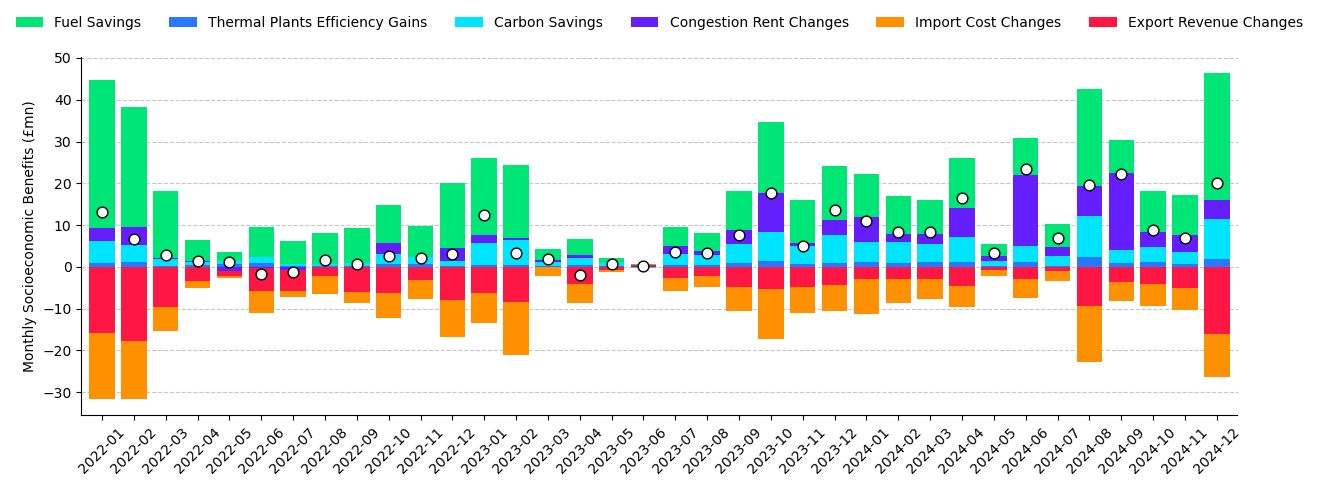

Yearly SEB Totals (£bn):
Month
2022    0.032715
2023    0.067680
2024    0.155422
Name: Value, dtype: float64


In [88]:
# Convert Month to datetime for proper ordering
plot_data['Month'] = pd.to_datetime(plot_data['Month'])

# Pivot the data to get components as columns
pivot_data = plot_data.pivot_table(index='Month', columns='Component', values='Value').mul(1e3)

# Define nicer labels for components
component_labels = {
    'import_costs_diff': 'Import Cost Changes',
    'export_revenues_diff': 'Export Revenue Changes',
    'fuel_savings': 'Fuel Savings',
    'balancing_markup': 'Thermal Plants Efficiency Gains',
    'carbon_savings': 'Carbon Savings',
    'congestion_rent_diff': 'Congestion Rent Changes'
}

# Define color schemes
positive_colors = {
    'fuel_savings': '#00e676',          # bright green
    'balancing_markup': '#2979ff',      # vibrant blue
    'carbon_savings': '#00e5ff',        # electric cyan
    'congestion_rent_diff': '#651fff',  # deep purple
    'import_costs_diff': '#ff9100',     # vivid orange
    'export_revenues_diff': '#ff1744'   # bright red
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 5))

# Split into positive and negative components
pos_data = pivot_data.copy()
neg_data = pivot_data.copy()
pos_data[pos_data < 0] = 0
neg_data[neg_data > 0] = 0

# Plot positive values (stacked upward)
pos_bars = pos_data.plot(kind='bar', stacked=True, ax=ax, width=0.8, color=[positive_colors.get(col, '#333333') for col in pos_data.columns])

# Plot negative values (stacked downward)
neg_bars = neg_data.plot(kind='bar', stacked=True, ax=ax, width=0.8, color=[positive_colors.get(col, '#333333') for col in neg_data.columns], legend=False)

# Calculate the total for each month
total_by_month = plot_data.groupby('Month')['Value'].sum()

# Plot the total as white dots with black edges
ax.scatter(range(len(total_by_month)), total_by_month.values * 1e3, color='white', edgecolor='black', s=60, zorder=10)

# Format x-axis to show month-year
ax.set_xticks(range(len(pivot_data)))
ax.set_xticklabels([d.strftime('%Y-%m') for d in pivot_data.index], rotation=45)

# Add labels and title
ax.set_ylabel('Monthly Socioeconomic Benefits (£mn)')
ax.set_xlabel('')

# Fix legend with proper labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    [by_label[label] for label in positive_colors.keys()], 
    [component_labels.get(label, label) for label in positive_colors.keys()],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=6,
    frameon=False,
)

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Calculate and print total SEB for each year
yearly_totals = plot_data.groupby([plot_data['Month'].dt.year])['Value'].sum()
print("Yearly SEB Totals (£bn):")
print(yearly_totals)

In [86]:
mp = pd.read_csv(Path.cwd().parent / 'summaries' / 'marginal_prices_summary_flex.csv', index_col=[0], parse_dates=True, header=[0,1])

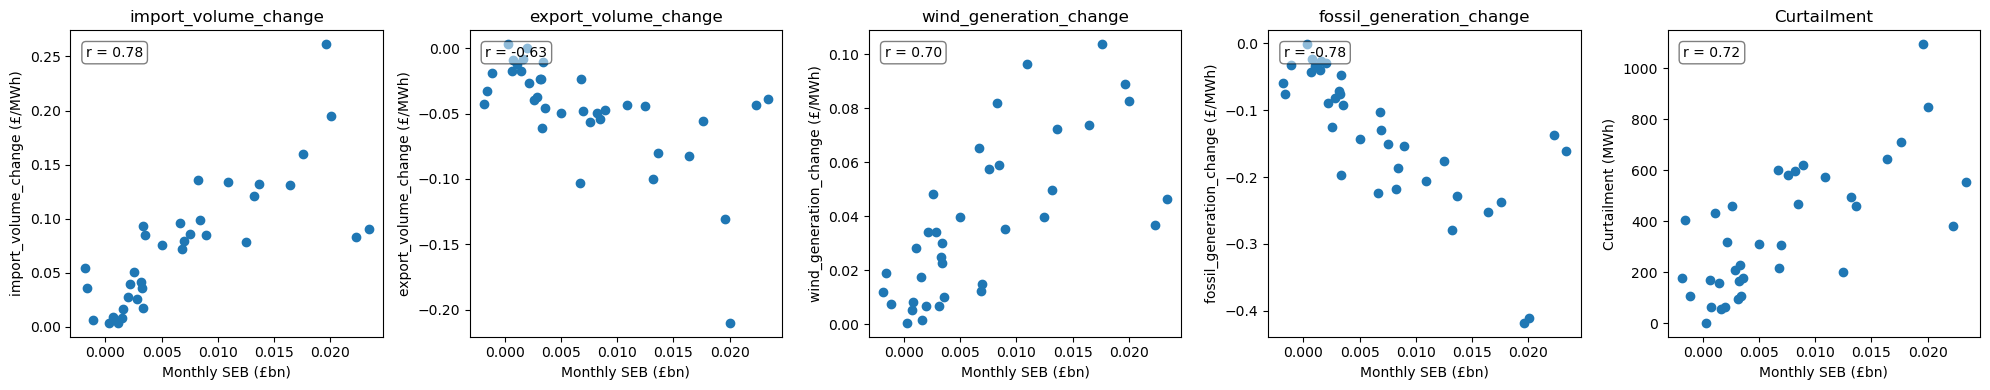

In [87]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
monthly_totals = plot_data.groupby('Month')['Value'].sum().values

# Components to plot
components = system_data['Component'].unique()

# Plot the first 4 components from system_data
for i, component in enumerate(components[:4]):  # Limit to first 4 components
    component_data = system_data[system_data['Component'] == component]
    if not component_data.empty:
        x = monthly_totals
        y = component_data['Value'].values
        
        # Calculate correlation
        correlation = np.corrcoef(x, y)[0, 1]
        
        # Create scatter plot
        axes[i].scatter(x, y)
        axes[i].set_title(f'{component_labels.get(component, component)}')
        axes[i].set_xlabel('Monthly SEB (£bn)')
        axes[i].set_ylabel(f'{component_labels.get(component, component)} (£/MWh)')
        axes[i].text(0.05, 0.95, f'r = {correlation:.2f}', transform=axes[i].transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Plot curtailment on the fifth axis
x = monthly_totals
y = corr_plot['curtailment'].values
correlation = np.corrcoef(x, y)[0, 1]

axes[4].scatter(x, y)
axes[4].set_title('Curtailment')
axes[4].set_xlabel('Monthly SEB (£bn)')
axes[4].set_ylabel('Curtailment (MWh)')
axes[4].text(0.05, 0.95, f'r = {correlation:.2f}', transform=axes[4].transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

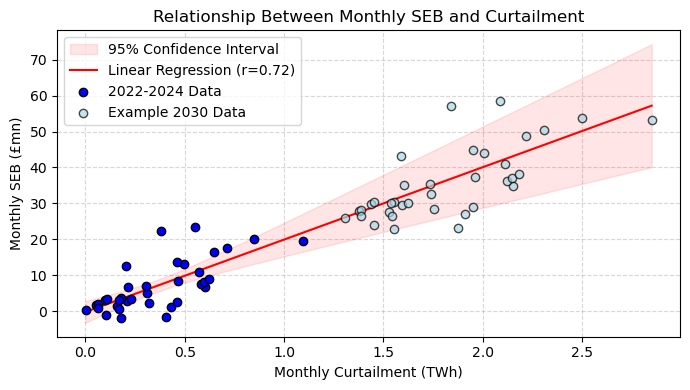

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Extract data for the plot - swap x and y
y = monthly_totals * 1000  # Now y is monthly_totals in £mn
x = corr_plot['curtailment'].values * 1e-3  # Now x is curtailment in GWh

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Calculate 95% confidence interval
n = len(x)
mean_x = np.mean(x)
# Sum of squares of x deviations
ss_x = np.sum((x - mean_x)**2)
# Standard error of the regression
se = np.sqrt(np.sum((y - (intercept + slope * x))**2) / (n - 2))
# Standard error of the slope
se_slope = se / np.sqrt(ss_x)
# t-value for 95% confidence interval
t_value = stats.t.ppf(0.975, n - 2)
# Confidence interval for the slope
ci = t_value * se_slope

# Get the full x range for the plot
x_min, x_max = ax.get_xlim()
x_full_range = np.linspace(x_min, x_max, 100)

# Create shifted data (scaled on both x and y axes)
x_mean = np.mean(x)
y_mean = np.mean(y)
x_shifted = (x - x_mean) * np.sqrt(2) + (x_mean * 5)  # Shift mean 5x to the right, multiply variance by 2
y_shifted = (y - y_mean) * np.sqrt(2) + (y_mean * 5)  # Also scale y values similarly

# Calculate confidence bands across the full range
x_full_range = np.linspace(x_min, x_shifted.max(), 1000)  # Increased number of points for smoother curve
y_upper = intercept + slope * x_full_range + t_value * se * np.sqrt(1/n + (x_full_range - mean_x)**2 / ss_x)
y_lower = intercept + slope * x_full_range - t_value * se * np.sqrt(1/n + (x_full_range - mean_x)**2 / ss_x)

# Create x values for regression line
x_line = np.linspace(x_min, x_shifted.max(), 100)
y_line = slope * x_line + intercept

# Plot confidence bands and regression line first (so they appear below the points)
ax.fill_between(x_full_range, y_lower, y_upper, color='red', alpha=0.1, label='95% Confidence Interval')
ax.plot(x_line, y_line, color='red', label=f'Linear Regression (r={r_value:.2f})')

# Plot the original scatter points with distinct black edges
ax.scatter(x, y, color='blue', edgecolor='black', linewidth=1, label='2022-2024 Data', zorder=10)

# Plot shifted data with distinct black edges
ax.scatter(x_shifted, y_shifted, color='lightblue', edgecolor='black', linewidth=1, alpha=0.7, label='Example 2030 Data', zorder=10)

# Add labels and legend
ax.set_xlabel('Monthly Curtailment (TWh)')
ax.set_ylabel('Monthly SEB (£mn)')
ax.set_title('Relationship Between Monthly SEB and Curtailment')
ax.legend()

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [51]:
plot_data['Component'].unique()

array(['import_costs_diff', 'export_revenues_diff', 'fuel_savings',
       'balancing_markup', 'carbon_savings', 'congestion_rent_diff'],
      dtype=object)

In [81]:
system_data

,Month,Component,Value
0,2022-01,import_volume_change,0.121340
1,2022-01,export_volume_change,-0.100376
2,2022-01,wind_generation_change,-0.342737
3,2022-01,fossil_generation_change,0.150524
4,2022-02,import_volume_change,0.095812
...,...,...,...
139,2024-11,fossil_generation_change,0.098071
140,2024-12,import_volume_change,0.195341
141,2024-12,export_volume_change,-0.209945
142,2024-12,wind_generation_change,-0.682882
